## Third attempt

Elimino ultima riga. Provo con file .numbers

Dovrò sicuramente riscaricare tutti i 9 gruppi

>>> INIZIO PIPELINE ANALISI GOOGLE TRENDS E PCA <<<

--- Inizio Caricamento Dati ---
Dati caricati con successo per 'Termini_Diretti' da 'Gruppo1(4).csv'
Dati caricati con successo per 'Alimentari' da 'Gruppo2(4).csv'
Dati caricati con successo per 'Energia' da 'Gruppo3(4).csv'
Dati caricati con successo per 'Abitazione' da 'Gruppo4(4).csv'
Dati caricati con successo per 'Trasporti' da 'Gruppo5(4).csv'
Dati caricati con successo per 'Politiche_Economiche' da 'Gruppo6(4).csv'
Dati caricati con successo per 'Aspettative_Consumatori' da 'Gruppo7(4).csv'
Dati caricati con successo per 'Sanita' da 'Gruppo8(4).csv'
Dati caricati con successo per 'Ricreazione' da 'Gruppo9(4).csv'
--- Fine Caricamento Dati ---

--- Inizio Identificazione Periodo Comune ---
Info (Periodo Comune): Periodo comune identificato: da 2004-01-01 a 2024-12-01
--- Fine Identificazione Periodo Comune ---

--- Inizio Combinazione Dati ---
Info (Combinazione): DataFrame combinato inizializzato con indice da 2004-01-01 a 20

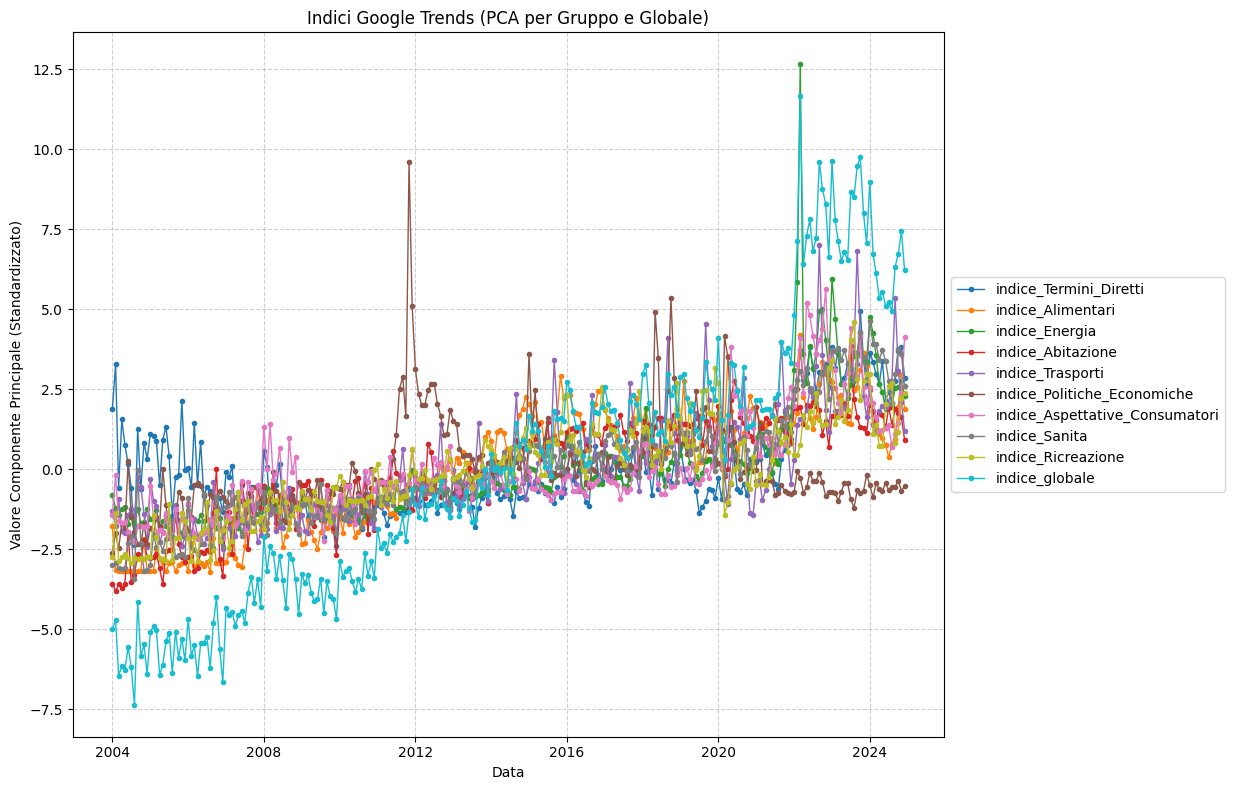

Info (Vis/Salvataggio): Indici salvati con successo in '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_google_trends_4.csv'
--- Fine Visualizzazione e Salvataggio Indici ---


>>> PIPELINE COMPLETATA <<<


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- CONFIGURAZIONE ---
PATH_DATI = "/Users/tommaso/Desktop/tesi-inflation-gt/Official_4"
PATH_SALVATAGGIO_INDICI = '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_google_trends_4.csv'

NOMI_GRUPPI_DICT = {
    "Gruppo1(4)": "Termini_Diretti",
    "Gruppo2(4)": "Alimentari",
    "Gruppo3(4)": "Energia",
    "Gruppo4(4)": "Abitazione",
    "Gruppo5(4)": "Trasporti",
    "Gruppo6(4)": "Politiche_Economiche",
    "Gruppo7(4)": "Aspettative_Consumatori",
    "Gruppo8(4)": "Sanita",
    "Gruppo9(4)": "Ricreazione"
}

# --- 1. CARICAMENTO DATI ---
def carica_dati_gt(path_csv, nomi_file_mappati):
    """
    Carica i dati di Google Trends da file CSV multipli.
    Normalizza i nomi delle colonne, imposta l'indice temporale.
    """
    dati_caricati_per_gruppo = {} # Questa è la variabile interna alla funzione
    print("--- Inizio Caricamento Dati ---")
    for nome_file_csv, nome_gruppo_logico in nomi_file_mappati.items():
        file_path = os.path.join(path_csv, f"{nome_file_csv}.csv")
        try:
            df = pd.read_csv(file_path, skiprows=2, header=0)
            df.columns = [str(col).strip().lower() for col in df.columns]
            colonna_data = None
            for possible_date_col in ['mese', 'month', 'settimana', 'week', 'giorno', 'day']:
                if possible_date_col in df.columns:
                    colonna_data = possible_date_col
                    break
            if colonna_data is None:
                raise ValueError(f"Nessuna colonna data standard ('mese', 'settimana', 'giorno', etc.) trovata in {nome_file_csv}")
            if colonna_data != 'mese':
                print(f"Info: Trovata colonna data '{colonna_data}' in {nome_file_csv}. Sarà usata come indice.")
            df.set_index(colonna_data, inplace=True)
            try:
                df.index = pd.to_datetime(df.index)
            except Exception as e_date:
                try:
                    df.index = pd.to_datetime(df.index, format="%Y-%m")
                except Exception:
                    raise e_date
            dati_caricati_per_gruppo[nome_gruppo_logico] = df
            print(f"Dati caricati con successo per '{nome_gruppo_logico}' da '{nome_file_csv}.csv'")
        except Exception as e:
            print(f"ERRORE nel caricamento di '{nome_file_csv}.csv': {e}")
    print("--- Fine Caricamento Dati ---\n")
    return dati_caricati_per_gruppo # La funzione restituisce questo dizionario


# --- 2. IDENTIFICAZIONE PERIODO COMUNE ---
def trova_periodo_comune(dati_dict_input):
    """
    Trova il periodo temporale comune (massimo inizio, minimo fine) tra tutti i DataFrame nel dizionario.
    """
    print("--- Inizio Identificazione Periodo Comune ---")
    if not dati_dict_input:
        print("Attenzione (Periodo Comune): Dizionario gruppi vuoto.")
        return None, None
    date_inizio_valide = []
    date_fine_valide = []
    for gruppo, df in dati_dict_input.items():
        if not df.empty and isinstance(df.index, pd.DatetimeIndex):
            date_inizio_valide.append(df.index.min())
            date_fine_valide.append(df.index.max())
        else:
            print(f"Attenzione (Periodo Comune): DataFrame per gruppo '{gruppo}' vuoto o con indice non Datetime. Escluso dal calcolo periodo.")
    if not date_inizio_valide or not date_fine_valide:
        print("Attenzione (Periodo Comune): Nessuna data valida trovata. Impossibile determinare periodo comune.")
        return None, None
    inizio_comune_calc = max(date_inizio_valide)
    fine_comune_calc = min(date_fine_valide)
    if inizio_comune_calc > fine_comune_calc:
        print(f"Attenzione (Periodo Comune): Nessun periodo comune valido trovato (max inizio: {inizio_comune_calc}, min fine: {fine_comune_calc}).")
        return None, None
    elif inizio_comune_calc == fine_comune_calc:
        print(f"Info (Periodo Comune): Periodo comune consiste in un solo punto dati: {inizio_comune_calc}")
    else:
        print(f"Info (Periodo Comune): Periodo comune identificato: da {inizio_comune_calc.strftime('%Y-%m-%d')} a {fine_comune_calc.strftime('%Y-%m-%d')}")
    print("--- Fine Identificazione Periodo Comune ---\n")
    return inizio_comune_calc, fine_comune_calc


# --- 3. COMBINAZIONE DATI SU PERIODO COMUNE ---
def combina_dati_su_periodo_comune(dati_dict_input, inizio_dt, fine_dt):
    """
    Filtra i dati per il periodo comune e li combina in un unico DataFrame.
    Aggiunge un prefisso del nome del gruppo a ciascuna colonna per unicità.
    """
    print("--- Inizio Combinazione Dati ---")
    if inizio_dt is None or fine_dt is None or not dati_dict_input:
        print("Errore (Combinazione): Periodo comune non valido o dati input vuoti. Impossibile combinare.")
        return None

    # Indice comune per il DataFrame combinato, frequenza mensile (Month Start)
    idx_comune = pd.date_range(start=inizio_dt, end=fine_dt, freq='MS')
    df_combinato_finale = pd.DataFrame(index=idx_comune)
    print(f"Info (Combinazione): DataFrame combinato inizializzato con indice da {inizio_dt.strftime('%Y-%m-%d')} a {fine_dt.strftime('%Y-%m-%d')} ({len(df_combinato_finale)} righe).")

    for nome_gruppo_logico, df_originale in dati_dict_input.items():
        if df_originale.empty or not isinstance(df_originale.index, pd.DatetimeIndex):
            print(f"Info (Combinazione): Gruppo '{nome_gruppo_logico}' vuoto o con indice non valido. Skippato.")
            continue

        # Filtra DataFrame del gruppo per il periodo comune
        df_periodo_gruppo = df_originale[(df_originale.index >= inizio_dt) & (df_originale.index <= fine_dt)]

        if df_periodo_gruppo.empty:
            print(f"Info (Combinazione): Gruppo '{nome_gruppo_logico}' non ha dati nel periodo comune. Skippato.")
            continue

        for col_originale_nome in df_periodo_gruppo.columns:
            # Crea un nome colonna univoco con prefisso del gruppo
            nome_colonna_con_prefisso = f"{nome_gruppo_logico}_{col_originale_nome}"

            # Reindicizza i dati della colonna del gruppo sull'indice comune del df_combinato_finale
            # Questo allinea le date e inserisce NaN se mancano dati per certe date nell'indice comune.
            serie_reindicizzata = df_periodo_gruppo[col_originale_nome].reindex(df_combinato_finale.index)
            df_combinato_finale[nome_colonna_con_prefisso] = serie_reindicizzata
            # print(f"Info (Combinazione): Colonna '{nome_colonna_con_prefisso}' aggiunta.") # Log verboso

    print(f"Info (Combinazione): DataFrame combinato finale con {df_combinato_finale.shape[0]} righe e {df_combinato_finale.shape[1]} colonne.")
    print("--- Fine Combinazione Dati ---\n")
    return df_combinato_finale


# --- 4. PULIZIA VALORI SPECIFICI DI GOOGLE TRENDS ('<1') ---
def pulisci_valori_gt(df_input):
    """
    Sostituisce i valori testuali come '<1' (comuni in Google Trends per bassa attività) con un valore numerico (0.5).
    Converte le colonne in numerico, forzando errori a NaN.
    """
    print("--- Inizio Pulizia Valori Google Trends ('<1') ---")
    if df_input is None:
        print("Errore (Pulizia GT): DataFrame input è None.")
        return None
    df_pulito = df_input.copy()

    for col in df_pulito.columns:
        # Regex per trovare '<1' o '< 1' (con o senza spazio)
        col_as_str = df_pulito[col].astype(str)
        num_sostituzioni = col_as_str.str.contains(r'< ?1').sum()

        if num_sostituzioni > 0:
            print(f"Info (Pulizia GT): Colonna '{col}': {num_sostituzioni} valori contenenti '<1' saranno sostituiti con 0.5.")
            df_pulito[col] = df_pulito[col].replace(to_replace=r'< ?1', value=0.5, regex=True)

        # Converte la colonna in numerico. errors='coerce' imposta a NaN i valori non convertibili.
        df_pulito[col] = pd.to_numeric(df_pulito[col], errors='coerce')

        if df_pulito[col].isnull().any():
            nan_count = df_pulito[col].isnull().sum()
            # Verifica se i NaN sono solo dovuti a coercizione di valori non '<1'
            # Se num_sostituzioni era 0 ma ci sono NaN, allora c'erano altri problemi.
            if num_sostituzioni == 0 and nan_count > 0:
                 print(f"Attenzione (Pulizia GT): Colonna '{col}' contiene {nan_count} NaN dopo conversione, non originati da sostituzione '<1'.")
            elif num_sostituzioni > 0 and df_pulito[col].isnull().sum() > 0 :
                 print(f"Info (Pulizia GT): Colonna '{col}' contiene {nan_count} NaN dopo conversione (alcuni potrebbero essere valori non convertibili diversi da '<1').")


    print("--- Fine Pulizia Valori Google Trends --- \n")
    return df_pulito


# --- 5. GESTIONE VALORI MANCANTI (NaN) ---
def gestisci_nan(df_input, strategy='fillna', fill_value=0, interpolate_method='linear'):
    """
    Gestisce i valori NaN nel DataFrame secondo una strategia specificata.
    Strategie: 'fillna', 'interpolate', 'dropna_rows', 'dropna_cols'.
    """
    print(f"--- Inizio Gestione NaN (Strategia: {strategy}) ---")
    if df_input is None:
        print("Errore (Gestione NaN): DataFrame input è None.")
        return None
    df_gestito = df_input.copy()

    nan_presenti_prima = df_gestito.isnull().values.any()
    if not nan_presenti_prima:
        print("Info (Gestione NaN): Nessun NaN trovato. Nessuna azione richiesta.")
        print("--- Fine Gestione NaN ---\n")
        return df_gestito

    print(f"Info (Gestione NaN): Trovati NaN. Applico strategia '{strategy}'.")
    if strategy == 'fillna':
        df_gestito = df_gestito.fillna(fill_value)
        print(f"Info (Gestione NaN): NaN sostituiti con {fill_value}.")
    elif strategy == 'interpolate':
        df_gestito = df_gestito.interpolate(method=interpolate_method, axis=0) # Interpola lungo le colonne (tempo)
        # Potrebbero rimanere NaN all'inizio/fine se non ci sono valori da cui interpolare
        if df_gestito.isnull().values.any():
            print(f"Info (Gestione NaN): NaN rimanenti dopo interpolazione (prob. inizio/fine serie). Riempiti con {fill_value}.")
            df_gestito = df_gestito.fillna(fill_value) # Fallback per NaN rimanenti
    elif strategy == 'dropna_rows':
        num_rows_before = len(df_gestito)
        df_gestito = df_gestito.dropna(axis=0)
        print(f"Info (Gestione NaN): Rimosse {num_rows_before - len(df_gestito)} righe contenenti NaN.")
    elif strategy == 'dropna_cols':
        num_cols_before = df_gestito.shape[1]
        df_gestito = df_gestito.dropna(axis=1)
        print(f"Info (Gestione NaN): Rimosse {num_cols_before - df_gestito.shape[1]} colonne contenenti NaN.")
    else:
        print(f"Attenzione (Gestione NaN): Strategia '{strategy}' non riconosciuta. NaN non gestiti.")
        print("--- Fine Gestione NaN ---\n")
        return df_input # Restituisce originale se strategia non valida

    if df_gestito.isnull().values.any():
        print("Attenzione (Gestione NaN): NaN ancora presenti dopo la gestione. Verifica la strategia e i dati.")
    else:
        print("Info (Gestione NaN): Tutti i NaN sono stati gestiti.")
    print("--- Fine Gestione NaN ---\n")
    return df_gestito


# --- 6. STANDARDIZZAZIONE SERIE (Z-SCORE) ---
def standardizza_serie_temporali(df_input):
    """
    Standardizza le serie temporali (colonne) del DataFrame usando Z-score (media 0, std dev 1).
    Essenziale per la PCA.
    """
    print("--- Inizio Standardizzazione Serie (Z-score) ---")
    if df_input is None:
        print("Errore (Standardizzazione): DataFrame input è None.")
        return None
    df_std = df_input.copy()

    for col in df_std.columns:
        if not pd.api.types.is_numeric_dtype(df_std[col]):
            print(f"Attenzione (Standardizzazione): Colonna '{col}' non numerica. Skippata.")
            continue

        media = df_std[col].mean()
        std_dev = df_std[col].std()

        if std_dev != 0:
            df_std[col] = (df_std[col] - media) / std_dev
        else:
            # Colonna costante. Dopo Z-score, dovrebbe essere tutta zero.
            df_std[col] = 0
            print(f"Info (Standardizzazione): Colonna '{col}' ha deviazione standard nulla. Impostata a 0.")
    print("--- Fine Standardizzazione Serie ---\n")
    return df_std


# --- 7. CREAZIONE INDICI PCA PER GRUPPO ---
def crea_indici_pca_per_gruppo(df_std_input, nomi_gruppi_mappati):
    """
    Applica PCA a ciascun gruppo di query (identificate da prefisso nel nome colonna).
    Estrae il primo componente principale per ogni gruppo.
    """
    print("--- Inizio Creazione Indici PCA per Gruppo ---")
    if df_std_input is None or df_std_input.empty:
        print("Errore (PCA Gruppi): DataFrame standardizzato input è None o vuoto.")
        return pd.DataFrame(index=df_std_input.index if df_std_input is not None else None) # Restituisce df vuoto con indice se possibile

    indici_pca_df = pd.DataFrame(index=df_std_input.index)

    for nome_gruppo_logico in nomi_gruppi_mappati.values():
        colonne_del_gruppo = [col for col in df_std_input.columns if col.startswith(f"{nome_gruppo_logico}_")]

        if not colonne_del_gruppo:
            print(f"Info (PCA Gruppi): Nessuna colonna trovata per il gruppo '{nome_gruppo_logico}'. Indice non creato.")
            indici_pca_df[f'indice_{nome_gruppo_logico}'] = np.nan # Colonna di NaN
            continue

        # Seleziona i dati solo per le colonne del gruppo corrente
        dati_gruppo_pca = df_std_input[colonne_del_gruppo].copy()

        # Rimuovi colonne con varianza nulla (già impostate a 0 dalla standardizzazione, ma una verifica ulteriore non nuoce)
        # O, più robustamente, colonne che sono costanti (varianza vicina a zero)
        dati_gruppo_pca_validi = dati_gruppo_pca.loc[:, dati_gruppo_pca.var() > 1e-9] # Tolleranza per errori floating point

        if dati_gruppo_pca_validi.shape[1] >= 1: # PCA necessita di almeno una variabile con varianza
            if dati_gruppo_pca_validi.shape[1] == 1: # Caso con una sola variabile valida
                print(f"Info (PCA Gruppi): Gruppo '{nome_gruppo_logico}' ha una sola variabile valida ('{dati_gruppo_pca_validi.columns[0]}'). Usata direttamente come indice.")
                indici_pca_df[f'indice_{nome_gruppo_logico}'] = dati_gruppo_pca_validi.iloc[:, 0]
            else: # Caso con 2+ variabili valide per PCA
                pca = PCA(n_components=1)
                try:
                    # Verifica NaN residui prima di fit_transform (non dovrebbe succedere se gestiti prima)
                    if dati_gruppo_pca_validi.isnull().values.any():
                        raise ValueError("NaN presenti nei dati del gruppo prima della PCA. Vanno gestiti.")
                    componente = pca.fit_transform(dati_gruppo_pca_validi)
                    indici_pca_df[f'indice_{nome_gruppo_logico}'] = componente.flatten()

                    print(f"\nGruppo '{nome_gruppo_logico}':")
                    print(f"  Varianza spiegata da PC1: {pca.explained_variance_ratio_[0]:.2%} (su {dati_gruppo_pca_validi.shape[1]} variabili)")
                    print("  Loadings (contributo variabili a PC1):")
                    for i, col_pca_nome in enumerate(dati_gruppo_pca_validi.columns):
                        print(f"    {col_pca_nome}: {pca.components_[0][i]:.4f}")
                except Exception as e_pca:
                    print(f"ERRORE durante PCA per gruppo '{nome_gruppo_logico}': {e_pca}")
                    indici_pca_df[f'indice_{nome_gruppo_logico}'] = np.nan
        else:
            print(f"Info (PCA Gruppi): Gruppo '{nome_gruppo_logico}' non ha variabili con varianza sufficiente dopo pulizia. Indice non creato.")
            indici_pca_df[f'indice_{nome_gruppo_logico}'] = np.nan
    print("--- Fine Creazione Indici PCA per Gruppo ---\n")
    return indici_pca_df


# --- 8. CREAZIONE INDICE PCA GLOBALE ---
def crea_indice_pca_globale(df_indici_gruppo_input):
    """
    Applica PCA agli indici di gruppo precedentemente calcolati per creare un indice globale.
    """
    print("--- Inizio Creazione Indice PCA Globale ---")
    if df_indici_gruppo_input is None or df_indici_gruppo_input.empty:
        print("Errore (PCA Globale): DataFrame indici di gruppo è None o vuoto.")
        return None # O un df vuoto con lo stesso indice se df_indici_gruppo_input non è None

    # Gestione NaN negli indici di gruppo: PCA non li accetta.
    # Qui si rimuovono le righe con QUALSIASI NaN. Potrebbe ridurre il dataset.
    # Valuta se interpolare o fillare prima, se più appropriato per non perdere periodi.
    indici_gruppo_per_pca_globale = df_indici_gruppo_input.dropna(axis=0, how='any')

    if indici_gruppo_per_pca_globale.empty:
        print("Attenzione (PCA Globale): Nessuna riga rimasta dopo rimozione NaN dagli indici di gruppo. Indice globale non creato.")
        return df_indici_gruppo_input # Restituisce originale con potenziale colonna NaN

    # Rimuovi colonne (indici di gruppo) con varianza nulla
    indici_gruppo_validi = indici_gruppo_per_pca_globale.loc[:, indici_gruppo_per_pca_globale.var() > 1e-9]

    if indici_gruppo_validi.shape[1] >= 1: # Necessaria almeno una colonna (indice di gruppo) con varianza
        if indici_gruppo_validi.shape[1] == 1:
             print(f"Info (PCA Globale): Un solo indice di gruppo valido ('{indici_gruppo_validi.columns[0]}'). Usato direttamente come indice globale.")
             # Allinea l'indice per l'assegnazione
             indice_globale_serie = indici_gruppo_validi.iloc[:,0].reindex(df_indici_gruppo_input.index)
             df_indici_gruppo_input['indice_globale'] = indice_globale_serie

        else: # PCA con 2+ indici di gruppo validi
            pca_glob = PCA(n_components=1)
            try:
                componente_globale = pca_glob.fit_transform(indici_gruppo_validi)
                # Crea una Serie pandas con l'indice corretto (quello dei dati usati per fit_transform)
                # e poi la assegna al DataFrame originale per mantenere tutte le date (con NaN dove non calcolato)
                indice_globale_serie = pd.Series(componente_globale.flatten(), index=indici_gruppo_validi.index)
                df_indici_gruppo_input['indice_globale'] = indice_globale_serie # Aggiunge come nuova colonna, allineando per indice

                print(f"\nIndice Globale:")
                print(f"  Varianza spiegata da PC1: {pca_glob.explained_variance_ratio_[0]:.2%} (su {indici_gruppo_validi.shape[1]} indici di gruppo)")
                print("  Loadings (contributo indici di gruppo a PC1 globale):")
                for i, col_idx_gruppo_nome in enumerate(indici_gruppo_validi.columns):
                    print(f"    {col_idx_gruppo_nome}: {pca_glob.components_[0][i]:.4f}")
            except Exception as e_pca_g:
                print(f"ERRORE durante PCA globale: {e_pca_g}")
                df_indici_gruppo_input['indice_globale'] = np.nan # In caso di errore
    else:
        print("Info (PCA Globale): Nessun indice di gruppo con varianza sufficiente per PCA globale. Indice globale non creato.")
        df_indici_gruppo_input['indice_globale'] = np.nan
    print("--- Fine Creazione Indice PCA Globale ---\n")
    return df_indici_gruppo_input


# --- 9. VISUALIZZAZIONE E SALVATAGGIO ---
def visualizza_e_salva_indici(df_indici_finali, path_salvataggio_csv):
    """
    Visualizza gli indici PCA e li salva in un file CSV.
    """
    print("--- Inizio Visualizzazione e Salvataggio Indici ---")
    if df_indici_finali is None or df_indici_finali.empty:
        print("Errore (Vis/Salvataggio): DataFrame indici finali è None o vuoto. Nessuna azione.")
        return

    # Visualizzazione
    if not df_indici_finali.select_dtypes(include=np.number).empty: # Controlla se ci sono colonne numeriche da plottare
        plt.figure(figsize=(15, 8))
        for col_nome in df_indici_finali.columns:
            if pd.api.types.is_numeric_dtype(df_indici_finali[col_nome]):
                 plt.plot(df_indici_finali.index, df_indici_finali[col_nome], label=col_nome, marker='.', linestyle='-', linewidth=1)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Legenda fuori dal grafico per chiarezza
        plt.title('Indici Google Trends (PCA per Gruppo e Globale)')
        plt.xlabel('Data')
        plt.ylabel('Valore Componente Principale (Standardizzato)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout(rect=[0, 0, 0.83, 1]) # Aggiusta layout per fare spazio alla legenda
        plt.show()
    else:
        print("Info (Vis/Salvataggio): Nessuna colonna numerica da visualizzare negli indici finali.")


    # Salvataggio
    try:
        # Crea la directory di destinazione se non esiste
        os.makedirs(os.path.dirname(path_salvataggio_csv), exist_ok=True)
        df_indici_finali.to_csv(path_salvataggio_csv, index=True)
        print(f"Info (Vis/Salvataggio): Indici salvati con successo in '{path_salvataggio_csv}'")
    except Exception as e_salva:
        print(f"ERRORE durante il salvataggio degli indici: {e_salva}")
    print("--- Fine Visualizzazione e Salvataggio Indici ---\n")


# --- ESECUZIONE PIPELINE ---
if __name__ == "__main__":
    print(">>> INIZIO PIPELINE ANALISI GOOGLE TRENDS E PCA <<<\n")

    # 1. Caricamento
    # La variabile 'dati_appena_caricati' ora contiene il dizionario restituito da carica_dati_gt
    dati_appena_caricati = carica_dati_gt(PATH_DATI, NOMI_GRUPPI_DICT)

    # 2. Periodo Comune
    # Passiamo 'dati_appena_caricati' (che è il risultato della Fase 1) direttamente a 'trova_periodo_comune'
    start_date, end_date = trova_periodo_comune(dati_appena_caricati) # MODIFICATO QUI

    # 3. Combinazione Dati
    # 'dati_appena_caricati' viene passato anche qui
    df_combinato = combina_dati_su_periodo_comune(dati_appena_caricati, start_date, end_date) # MODIFICATO QUI

    # 4. Pulizia Valori GT ('<1')
    df_pulito_gt = pulisci_valori_gt(df_combinato)

    # 5. Gestione NaN (Scegliere la strategia più adatta)
    df_senza_nan = gestisci_nan(df_pulito_gt, strategy='fillna', fill_value=0)

    # 6. Standardizzazione
    df_standardizzato = standardizza_serie_temporali(df_senza_nan)

    # 7. PCA per Gruppo
    df_indici_per_gruppo = crea_indici_pca_per_gruppo(df_standardizzato, NOMI_GRUPPI_DICT)

    # 8. PCA Globale
    df_indici_finali_con_globale = crea_indice_pca_globale(df_indici_per_gruppo)

    # 9. Visualizzazione e Salvataggio
    visualizza_e_salva_indici(df_indici_finali_con_globale, PATH_SALVATAGGIO_INDICI)

    print("\n>>> PIPELINE COMPLETATA <<<")
